## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor,Pool
RANDOM_STATE=190922

In [2]:
data_list=['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
data=dict.fromkeys(data_list)
for i in data:
    result_1 = i + '.csv'
    result_2 = '/datasets/final_steel/' + i + '.csv'

    try:
        data[i] = pd.read_csv(result_1)
    except:
        data[i] = pd.read_csv(result_2)
    else:
        print('Error')

In [3]:
data_arc = data['data_arc']
data_bulk = data['data_bulk']
data_bulk_time = data['data_bulk_time']
data_gas = data['data_gas']
data_temp = data['data_temp']
data_wire = data['data_wire']
data_wire_time = data['data_wire_time']

## Исследование данных

### Данные об электродах

In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
len(data_arc['key'].unique())

3214

In [7]:
data_arc['key'].count() / data_arc['key'].nunique()

4.628500311138768

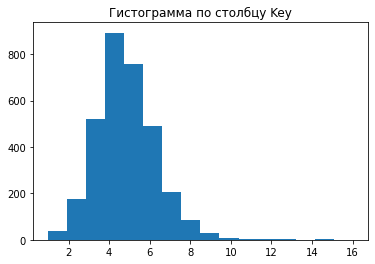

In [8]:
plt.hist((list(data_arc['key'].value_counts())), bins=16)
plt.title('Гистограмма по столбцу Key')
plt.show()

In [9]:
(data_arc.isna().mean()*100).round(1)

key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

In [10]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

In [11]:
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [12]:
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [13]:
data_arc.duplicated().sum()

0

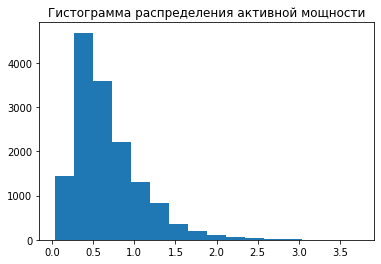

In [14]:
plt.hist((data_arc['Активная мощность']), bins=16)
plt.title('Гистограмма распределения активной мощности')
plt.show()

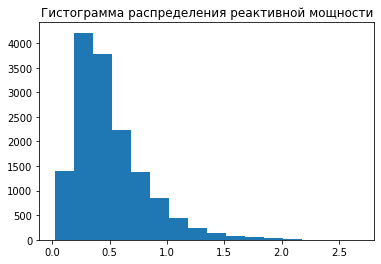

In [15]:
plt.hist(data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'], bins=16)
plt.title('Гистограмма распределения реактивной мощности')
plt.show()

Выводы:
1. В этой таблице пропусков нет
2. Всего 3214 ключей
3. В среднем сделано по 4,6 обработки для каждой партии, значения варьируются от 1 до 16. Нужно создать отдельный признак по количеству нагревов, посмотреть его корреляцию с таргетом
4. В активной мощности нет аномалий 
5. Реактивная мощность имеет аномалию - одно значение меньше 0. И хотя мощность может быть отрицательного значения, оно еще и намного больше чем остальные значения. В предобработки нужно будет ее исключить или заменить
6. Создадим признака полной мощности, работы и  рассмотреть, какая у них корреляция с таргетом 
7. Нужно изменить формат данных на datetime в столбцах Начало нагрева дугой и Конец нагрева дугой, затем проверить, идут ли они по порядку
8. Явных дубликатов в таблице нет

### Данные о подаче сыпучих материалов (объём)

In [16]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [17]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [18]:
len(data_bulk['key'].unique())

3129

In [19]:
data_bulk.duplicated().sum()

0

In [20]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


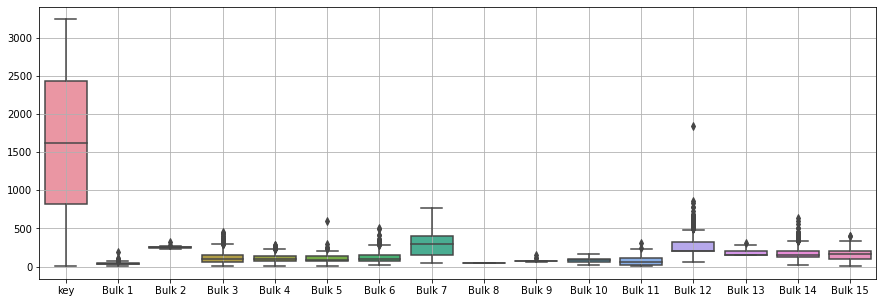

In [21]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk)
plt.grid();

Выводы:
1. Всего 3129, меньше чем в предыдущей таблицы 
2. Много пропусков, связано с технологическим процессом. Нужно заменить на 0, так как пропуски говорят от том, что данная операция не проводилась.
3. Аномальных значений не замечено, все значения больше нуля
4. Добавка 8 использовалось только 1 раз, стоит его удалить, так как слишком мало результатов. Добавки 2,7,13 используются меньше 30 раз, возможно, их тоже нужно будет удалить, если точность моделей будет маленькой
5. Явных дубликатов в таблице нет

### Данные о подаче сыпучих материалов (время)

In [22]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [23]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [24]:
len(data_bulk_time['key'].unique())

3129

Выводы:
1. Всего 3129, как в предыдущей таблице 
2. Много пропусков, связано с предыдущей таблицей загрузок
3. Нужно изменить формат данных на datetime
4. Расчитать время подачи сыпучих материалов, возможно, будет корреляция с температурой

### Данные о продувке сплава газом

In [25]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [26]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [27]:
len(data_gas['key'].unique())

3239

In [28]:
data_gas.duplicated().sum()

0

In [29]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [30]:
(data_gas.isna().mean()*100).round(1)

key      0.0
Газ 1    0.0
dtype: float64

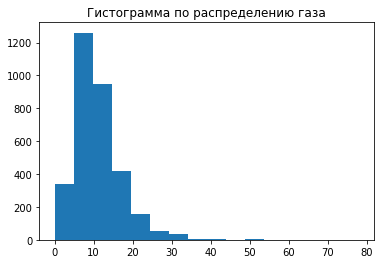

In [31]:
plt.hist((data_gas['Газ 1']), bins=16)
plt.title('Гистограмма по распределению газа')
plt.show()

Выводы:
1. Пропусков нет
2. Аномалий нет
3. Объем подаваемого газа составляет в среднем 11, достигая максимума примерно до 78. Но на данном этапе нет информации о допустимых границах этого параметра технологическом процессе, оставим все имеющиеся значения без удаления.
4. Явных дубликатов в таблице нет

### Результаты измерения температуры

In [32]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [34]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [35]:
(data_temp.isna().mean()*100).round(1)

key              0.0
Время замера     0.0
Температура     18.2
dtype: float64

In [36]:
data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [37]:
data_temp.duplicated().sum()

0

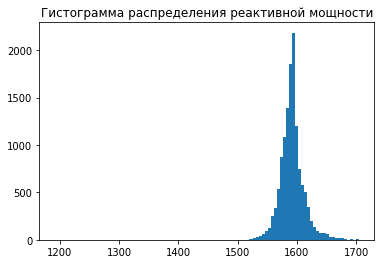

In [38]:
plt.hist(data_temp['Температура'], bins=100)
plt.title('Гистограмма распределения реактивной мощности')
plt.show()

Выводы:
1. В таблице достаточно много пропусков, 18.2 %, часть данных заказчик хочет использовать в качестве отложенного теста, поэтому скрыл их
2. Таргет - последняя температура по ключу, поэтому удаляем те ключи, где нет последней температуры, так как ее заменить нельзя
3. Нужно изменить формат данных на datetime
4. Преобразовать данные в две колонки, использовать только первую и последнюю температуру
5. Температура только положительная, аномалий не наблюдается 
6. Явных дубликатов в таблице нет
7. Температура находится в районе от 1191 до 1705 градусов, среднее - 1592 градуса

### Данные о проволочных материалах (объём)

In [39]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [41]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [42]:
data_wire.duplicated().sum()

0

In [43]:
len(data_wire['key'].unique())

3081

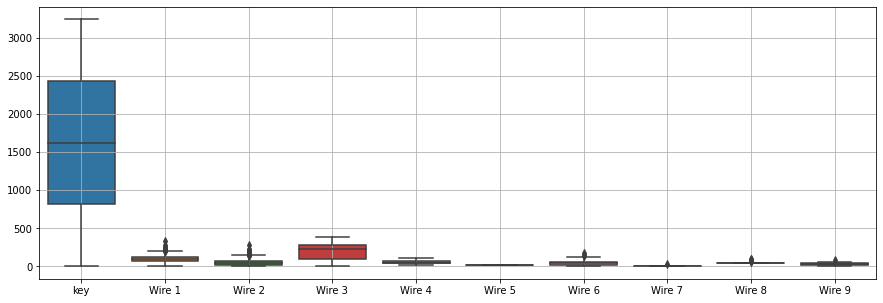

In [44]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire)
plt.grid();

Выводы:
1. В данной таблице меньше всего уникальных ключей - 3081
2. Много пропусков в силу технологического процесса, заменить на 0, как в других таблицах
3. 5 тип проволки использовался только один раз, а тип 7 и 8 меньше 20, удалю ключ 5 типа, так как мало данных для предсказания, 7 и 8 возможно тоже удалю, если будет плохая точность
4. Явных дубликатов в таблице нет
5. Видимых анамалий в таблице нет

### Данные о проволочных материалах (время)

In [45]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [47]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [48]:
len(data_wire_time['key'].unique())

3081

Выводы:
1. Всего 3081, как в предыдущей таблице 
2. Много пропусков, связано с предыдущей таблицей загрузок
3. Нужно изменить формат данных на datetime
4. Расчитать время подачи проволочных материалов, возможно, будет корреляция с температурой

## Подготовка данных

### Данные об электродах

In [49]:
data_arc.columns=['key', 'start_time', 'finish_time', 'active_power', 'reactive_power']

In [50]:
data_arc.corr()

,key,active_power,reactive_power
key,1.000000,-0.021382,-0.004396
active_power,-0.021382,1.000000,0.054437
reactive_power,-0.004396,0.054437,1.000000


In [51]:
data_arc = data_arc[data_arc['reactive_power'] > 0]

Создадим признака полной мощности:

Полная мощность по формуле:

где: P — активная мощность, Q — реактивная мощность 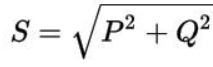

In [113]:
data_arc['full_power']= np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
pd.options.mode.chained_assignment = None

Изменим формат данных на datetime в столбцах Начало нагрева дугой и Конец нагрева дугой, затем проверим, идут ли они по порядку


In [53]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'])
pd.options.mode.chained_assignment = None
data_arc['finish_time'] = pd.to_datetime(data_arc['finish_time'])
pd.options.mode.chained_assignment = None
data_arc['duration'] = (data_arc['finish_time'] - data_arc['start_time']).astype('timedelta64[s]')

Проверим

In [54]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14875 non-null  int64         
 1   start_time      14875 non-null  datetime64[ns]
 2   finish_time     14875 non-null  datetime64[ns]
 3   active_power    14875 non-null  float64       
 4   reactive_power  14875 non-null  float64       
 5   full_power      14875 non-null  float64       
 6   duration        14875 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 929.7 KB


In [55]:
(data_arc['finish_time'] - data_arc['start_time']).describe()

count                        14875
mean     0 days 00:02:51.675159663
std      0 days 00:01:38.188758501
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
dtype: object

Время окончания процесса должно быть больше времени начала, так как у нас самое минимальное значение разницы процессов положительное - так оно и есть

In [56]:
func = {
    'key'            : 'count', 
    'start_time' : 'first',
    'finish_time': 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'full_power'    : 'mean',
    'duration'   : 'sum'
}

In [57]:
data_arc_group = data_arc.groupby('key').agg(func).rename(columns={'key':'count_arc'})
data_arc_group

,count_arc,start_time,finish_time,active_power,reactive_power,full_power,duration
key,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1.165279,1098.0
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,0.912304,811.0
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,0.597907,655.0
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,0.953741,741.0
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,1.008939,869.0
...,...,...,...,...,...,...,...
3237,5,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,0.968996,909.0
3238,3,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,0.898847,546.0
3239,8,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,0.701485,1216.0


In [58]:
data_arc_group.drop(['start_time','finish_time'], axis=1, inplace=True)

### Данные о подаче сыпучих материалов (объём)

Заменим пропуски на 0, так как пропуски говорят от том, что данная операция не проводилась.

In [59]:
data_bulk = data_bulk.fillna(0)

Переименуем

In [60]:
data_bulk.columns=['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

Удалим добавку, которая использовалась один раз (добавка 8)

In [61]:
data_bulk.drop('bulk_8',axis=1, inplace=True)
data_bulk

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


### Данные о подаче сыпучих материалов (время)

Переведем формат данных на datetime

Нужно изменить формат данных на datetime
Расчитать время подачи сыпучих материалов, возможно, будет корреляция с температурой

In [62]:
data_bulk_time.columns=['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']

In [63]:
for i in range(1,16):
    data_bulk_time['bulk_' + str(i)] = pd.to_datetime(data_bulk_time['bulk_' + str(i)])

In [64]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [65]:
data_bulk_time.set_index('key', inplace=True)

In [66]:
data_bulk_time['start_time_wire'] = data_bulk_time.min(axis=1)
data_bulk_time['finish_time_wire'] = data_bulk_time.max(axis=1)

In [67]:
data_bulk_time

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,start_time_wire,finish_time_wire
key,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:21:30
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:38
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:31:06
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:43
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:51:28
3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:39:11
3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:51:58


In [68]:
data_bulk_time['duration_bulk'] = (data_bulk_time['finish_time_wire'] - data_bulk_time['start_time_wire']).astype('timedelta64[s]')

In [69]:
data_bulk_time = data_bulk_time['duration_bulk']

### Данные о продувке сплава газом

In [70]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

### Данные о проволочных материалах (объём)

In [71]:
data_wire = data_wire.fillna(0)

In [72]:
data_wire.columns=['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

In [73]:
data_wire.drop('wire_5',axis=1, inplace=True)
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Выполнила преобразования согласно плану


### Данные о проволочных материалах (время)

In [74]:
data_wire_time.columns=['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

In [75]:
for i in range(1,10):
    data_wire_time['wire_' + str(i)] = pd.to_datetime(data_wire_time['wire_' + str(i)])

In [76]:
data_wire_time.set_index('key', inplace=True)

In [77]:
data_wire_time['start_time_wire'] = data_wire_time.min(axis=1)
data_wire_time['finish_time_wire'] = data_wire_time.max(axis=1)

In [78]:
data_wire_time

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,start_time_wire,finish_time_wire
key,,,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:11:41,2019-05-03 11:11:41
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:10,2019-05-03 11:46:10
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:47,2019-05-03 12:13:47
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:05,2019-05-03 12:48:05
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:18:15,2019-05-03 13:32:06
...,...,...,...,...,...,...,...,...,...,...,...
3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:50:20,2019-08-31 22:50:20
3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:38:24,2019-08-31 23:38:24
3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:50:43,2019-09-01 01:50:43


In [79]:
data_wire_time['duration_wire'] = (data_wire_time['finish_time_wire'] - data_wire_time['start_time_wire']).astype('timedelta64[s]')

In [80]:
data_wire_time = data_wire_time['duration_wire']

In [81]:
data_wire_time

key
1         0.0
2         0.0
3         0.0
4         0.0
5       831.0
        ...  
3237      0.0
3238      0.0
3239      0.0
3240      0.0
3241      0.0
Name: duration_wire, Length: 3081, dtype: float64

### Результаты измерения температуры

In [82]:
data_temp.columns=['key', 'time', 'temperature']

In [83]:
data_temp

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [84]:
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [85]:
data_temp_group = data_temp.groupby('key')['time'].agg(['first', 'last']).reset_index().rename(columns=
                                                            {'first':'start_temp','last':'finish_temp'})
data_temp_group

,key,start_temp,finish_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16


In [86]:
data_temp_group = data_temp_group.merge(data_temp, left_on=['key', 'start_temp'], right_on=['key', 'time']).rename(columns={'temperature':'start_temperature'})
data_temp_group = data_temp_group.merge(data_temp, left_on=['key', 'finish_temp'], right_on=['key', 'time']).rename(columns={'temperature':'finish_temperature'})
data_temp_group

,key,start_temp,finish_temp,time_x,start_temperature,time_y,finish_temperature
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN


In [87]:
data_temp_group.describe()

,key,start_temperature,finish_temperature
count,3216.000000,3216.000000,2477.000000
mean,1622.199316,1588.592040,1595.334275
std,935.088523,29.137454,16.019339
min,1.000000,1191.000000,1541.000000
25%,815.750000,1572.000000,1587.000000
50%,1622.500000,1588.000000,1593.000000
75%,2431.250000,1606.000000,1599.000000
max,3241.000000,1684.000000,1700.000000


In [88]:
data_temp_group.drop(['time_x', 'time_y','start_temp', 'finish_temp'], axis=1, inplace=True)

Удалим значения с пропусками по температуре

In [89]:
data_temp_group.dropna(inplace=True)

In [90]:
data_temp_group = data_temp_group[data_temp_group['start_temperature'] > 1500]

In [91]:
data_temp_group

,key,start_temperature,finish_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


## Объединение таблиц 

In [92]:
data_temp_group = data_temp_group.set_index('key')
data_bulk = data_bulk.set_index('key')
data_gas = data_gas.set_index('key')
data_wire = data_wire.set_index('key')

In [93]:
data = data_temp_group.join([data_arc_group, data_bulk,data_wire,data_gas], how='inner')
data

,start_temperature,finish_temperature,count_arc,active_power,reactive_power,full_power,duration,bulk_1,bulk_2,bulk_3,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.975629,0.636648,1.165279,1098.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,4,0.763150,0.499528,0.912304,811.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,5,0.505176,0.319815,0.597907,655.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,4,0.802313,0.515074,0.953741,741.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,4,0.836793,0.563161,1.008939,869.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,4,0.802673,0.590194,0.996717,723.0,0.0,0.0,21.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,6,0.700511,0.468364,0.842839,940.0,0.0,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,3,0.737460,0.617090,0.961672,569.0,0.0,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


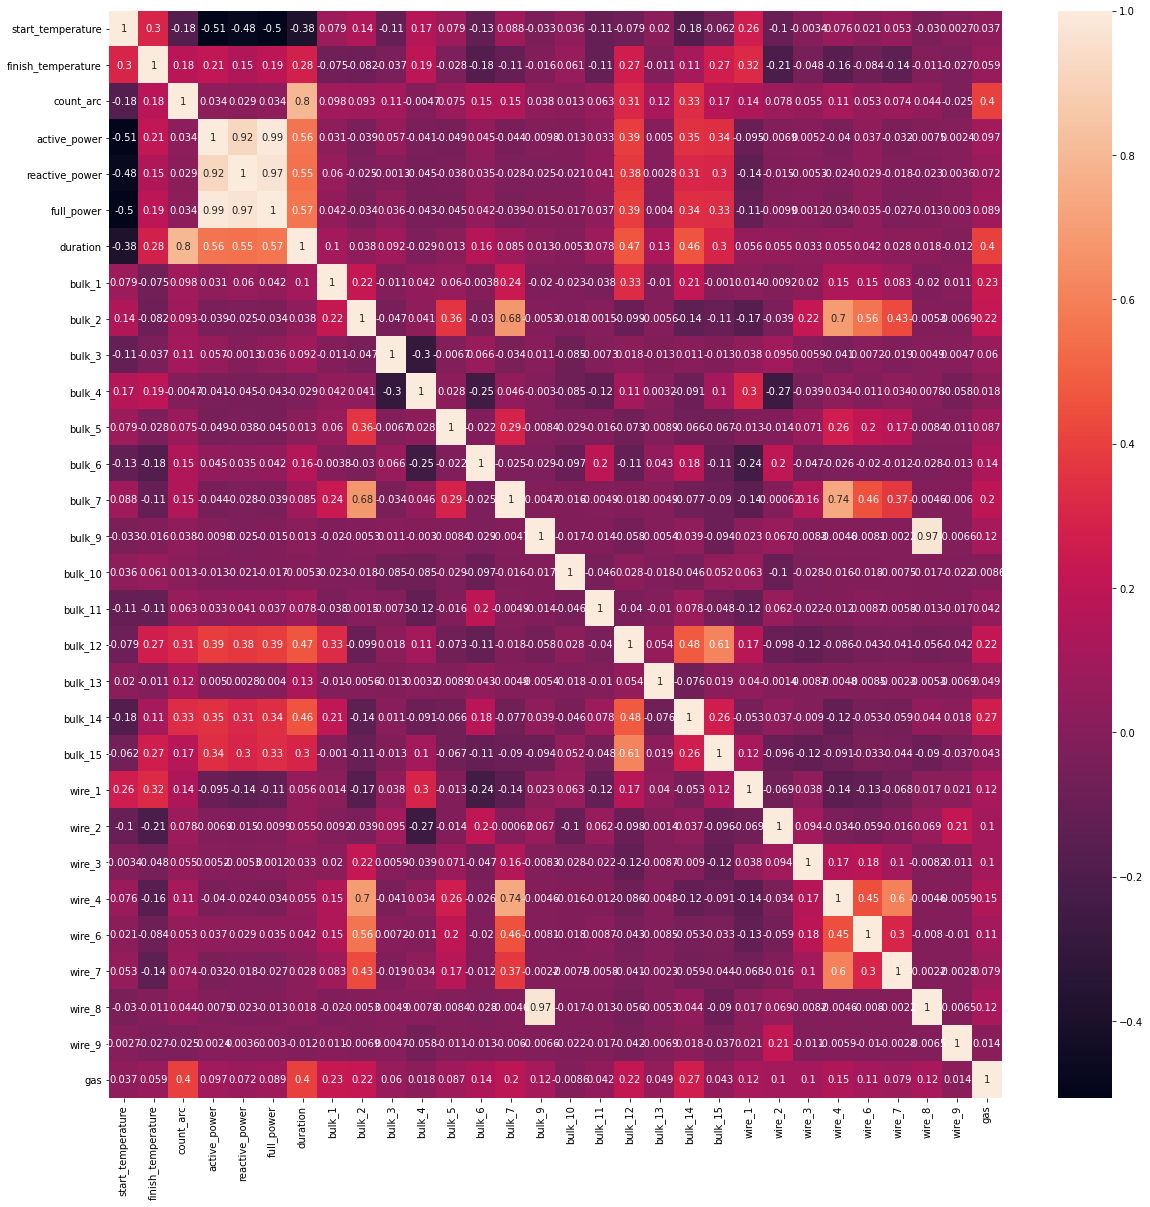

In [94]:
plt.figure(figsize=(20,20))
corr = data.corr()
sns.heatmap(corr, annot=True)
plt.show()

Удаляем реактивную мощность, т.к. она коррелирует с активной мощностью. Удаление признака bulk_8 перенесла наверх, так как он используется только один раз. Остальное оставила. Значения корреляций тоже удалила, оставила только тепловую карту.

In [95]:
data = data.drop(['reactive_power'], axis=1)

In [96]:
data.corr()['finish_temperature'] 

start_temperature     0.301961
finish_temperature    1.000000
count_arc             0.180783
active_power          0.211099
full_power            0.191046
duration              0.278558
bulk_1               -0.075233
bulk_2               -0.082466
bulk_3               -0.036767
bulk_4                0.188100
bulk_5               -0.028365
bulk_6               -0.181880
bulk_7               -0.107289
bulk_9               -0.016081
bulk_10               0.061345
bulk_11              -0.114777
bulk_12               0.267379
bulk_13              -0.010925
bulk_14               0.114520
bulk_15               0.266386
wire_1                0.317702
wire_2               -0.206837
wire_3               -0.047548
wire_4               -0.159737
wire_6               -0.084049
wire_7               -0.137275
wire_8               -0.010772
wire_9               -0.027496
gas                   0.059036
Name: finish_temperature, dtype: float64

In [97]:
data

,start_temperature,finish_temperature,count_arc,active_power,full_power,duration,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5,0.975629,1.165279,1098.0,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,4,0.763150,0.912304,811.0,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,5,0.505176,0.597907,655.0,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,4,0.802313,0.953741,741.0,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,4,0.836793,1.008939,869.0,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,4,0.802673,0.996717,723.0,0.0,0.0,21.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,6,0.700511,0.842839,940.0,0.0,0.0,0.0,63.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,3,0.737460,0.961672,569.0,0.0,0.0,0.0,85.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


## Обучение моделей

In [98]:
X = data.drop('finish_temperature', axis=1)
y = data['finish_temperature']

In [99]:
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [100]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1743 entries, 905 to 68
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temperature  1743 non-null   float64
 1   count_arc          1743 non-null   int64  
 2   active_power       1743 non-null   float64
 3   full_power         1743 non-null   float64
 4   duration           1743 non-null   float64
 5   bulk_1             1743 non-null   float64
 6   bulk_2             1743 non-null   float64
 7   bulk_3             1743 non-null   float64
 8   bulk_4             1743 non-null   float64
 9   bulk_5             1743 non-null   float64
 10  bulk_6             1743 non-null   float64
 11  bulk_7             1743 non-null   float64
 12  bulk_9             1743 non-null   float64
 13  bulk_10            1743 non-null   float64
 14  bulk_11            1743 non-null   float64
 15  bulk_12            1743 non-null   float64
 16  bulk_13            1743 

In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
pipeline = Pipeline([('Scaler', StandardScaler()),("regressor", DummyRegressor(strategy='mean'))])
pipeline.fit(features_train, target_train)
predicted_target = pipeline.predict(features_test)

print('MAE -', mean_absolute_error(target_test, predicted_target))

MAE - 8.406533349894426


DummyRegressor как точка отсчета качества моделей

In [103]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [104]:
reg = linear_model.LinearRegression()
scoring = 'neg_mean_absolute_error'
print('MAE ', (cross_val_score(reg,features_train, target_train, cv=10,scoring=scoring).mean())*-1)

MAE  6.240475934918062


In [105]:
param_grid = [{'max_depth': [3, 5, 10]}]
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_absolute_error')
grid_search.fit(features_train, target_train)
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(mean_score, params)

-7.536758179010033 {'max_depth': 3}
-7.231048620474897 {'max_depth': 5}
-7.6413560751385905 {'max_depth': 10}


In [106]:
grid_search.best_score_

-7.231048620474897

Весьма неплохо себя показала линейная регрессия, а вот дерево решений показывает очень плохое МАЕ.

In [107]:

parameters_cat =[{'depth' : [6, 8, 10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations' : [30, 50, 100]
                 }]
catboost = CatBoostRegressor(verbose = False)
catboost_grid = GridSearchCV(catboost, parameters_cat, scoring = 'neg_mean_absolute_error', cv = 5)

In [108]:
results = catboost_grid.fit(features_train,target_train)

In [109]:
catboost_grid.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [110]:
results

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f30404cc490>,
             param_grid=[{'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                          'learning_rate': [0.01, 0.05, 0.1]}],
             scoring='neg_mean_absolute_error')

In [111]:
print('MAE на кросс-валидации:', round(results.best_score_, 2))

MAE на кросс-валидации: -6.02


## Тестирование

In [112]:
model = CatBoostRegressor(depth=8, learning_rate=0.1, random_state=RANDOM_STATE, iterations=100,verbose = False) 
model.fit(features_train,target_train)
predicted_target = model.predict(features_test)
print('MAE -', round(mean_absolute_error(target_test, predicted_target),1))

MAE - 6.0


На этапе предобработки были изучены таблицы измерений различных показателей при получении стали. Были удалены пропуски, аномальные значения, добавлены новые показатели. Проведено исследование нескольких моделей, качество моделей оценено при помощи МАЕ.Параметры моделей были подобраны разными способами, в том числе автоматическим. Лучше всего показал себя CatBoost, который на кросс-валидации дает значение на 3 меньше чем DummyRegressor, а на тестовой выборке дает MAE - 6